# Introduction

>

# Importing the libraries and setting default values

In [869]:
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import stats
from scipy.stats import variation
from os import listdir
from os.path import isfile, join
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import utils
label_encoder = LabelEncoder()
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
import pylab
import matplotlib
import warnings
import boto3
from sagemaker import get_execution_role

warnings.simplefilter('ignore')

# Below are the values that are set as default values for the figures in this report.  
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(font_scale = 1.5)

%matplotlib inline 

In [870]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 150)

# Extract, Transfrom, Load (ETL) data

### Questionaire dataset

In [871]:
bucket='insightdata-zahra'
data_key = 'DATATOUSEwarehouse_03_14_20forZahra.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df=pd.read_csv(data_location)

In [872]:
# to group the columns by their types
# df.columns.to_series().groupby(df.dtypes).groups

In [873]:
print('The dataset has {} columns and {} rows.'.format(df.shape[1],df.shape[0]))

The dataset has 99 columns and 357692 rows.


In [874]:
df.head(5)

,Survey,id,participant,Survey Code,started,ti_1-resources,ti_2,ti_3,ti_4-giving extra,ti_5-ppl cooperate,...,Department Code,Department Name,Hire Date,Job Title,Region ID,Region Name,State,Sub-team,Supervisor Name,Team
0,1,103695,345311,43233,True,4,5,3,1,3,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
1,1,103453,345291,90973,True,5,5,5,5,5,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
2,1,114433,345282,15724,True,0,0,0,0,0,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
3,1,110803,345297,84210,True,5,5,5,4,4,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN
4,1,112815,345272,75834,True,4,5,4,4,4,...,NaN,Resident Care,NaN,RESIDENT CARE ASSISTANT,NaN,NaN,NaN,NaN,NaN,NaN


In [875]:
# rename the columns' names and remove the text that accompany some of the columns' names
clp = df.columns.str.extract("(\S{2}_\d{1,})")
dict(zip(df.columns[5:65].values,clp[5:65].values[:,0]))
df.rename(columns = dict(zip(df.columns[5:65].values,clp[5:65].values[:,0])),inplace=True)

In [876]:
df['ti_Overall'] = df['ti_60']>3
df['E-Score'] = df['ti_positive']/(df['ti_positive']+df['ti_inconsistent']+df['ti_negative'])
df['Target'] = df['E-Score']>.8
df['#Responses'] = df['ti_inconsistent']+df['ti_positive']+df['ti_negative']

In [877]:
df['LeftAt'] = df.iloc[:,5:65].iloc[:,::-1].cumsum(axis = 1).iloc[:,::-1].idxmin(axis = 1).str.extract("\S{2}_(\d{1,})")

### The 103 columns in the above dataframe are as follows:
>  
**C0**: Index<br>
**C1**: **Survey** can be considered as the id of the organization <br>
**C2--C4**: *ignore* <br>
**C5--C64**:
**ti_1** to **ti_60**    Trusted index, 60 standard workplace questions answered on a likert 5-point scale<br>
**C61**: **ti_positive** Number of 5 and 4 responses<br>
**C62**: **ti_inconsistent** Number of 3 responses<br>
**C63**: **ti_negative** Number of 1 and 2 responses<br>
**C64--C78**: *ignore* <br>
**C79**: **Location Name**<br>
**C81**: **Department Name**<br>
**C82--C99**: *ignore* <br>
**C100**: **ti_Overall** Ranking of the workplace averall <br>
**C101**: **Score** Number of 4 and 5 responses to the number of all responses for each employee<br>
**C101**: **Target** It is 1 for scores bigger than .8 and 0 otherwise<br>
**C103**: **#Responses** Total number of responses<br>

In [878]:
df.describe()

,Survey,id,participant,ti_1,ti_2,ti_3,ti_4,ti_5,ti_6,ti_7,...,ti_56,ti_57,ti_58,ti_59,ti_60,ti_positive,ti_inconsistent,ti_negative,E-Score,#Responses
count,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,...,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,357692.000000,202722.000000,357692.000000
mean,118.952096,348566.035184,592473.881392,2.390769,2.515580,2.217399,2.218873,2.191743,2.286464,2.289313,...,2.290345,2.250685,2.187829,2.208227,2.321643,25.298746,5.189809,2.613136,0.761223,33.101691
std,64.052365,171298.507837,196470.308034,2.227446,2.305769,2.138632,2.120208,2.088734,2.175524,2.187275,...,2.189597,2.182542,2.138007,2.136333,2.230269,25.899901,9.753916,7.747756,0.291191,29.391860
min,1.000000,31.000000,50466.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,202772.750000,435831.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000
50%,122.000000,334185.500000,569923.500000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,16.000000,0.000000,0.000000,0.900000,58.000000
75%,186.000000,527634.250000,784568.250000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,4.000000,4.000000,4.000000,4.000000,5.000000,55.000000,6.000000,1.000000,1.000000,60.000000
max,219.000000,626424.000000,921159.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,60.000000,60.000000,60.000000,1.000000,60.000000


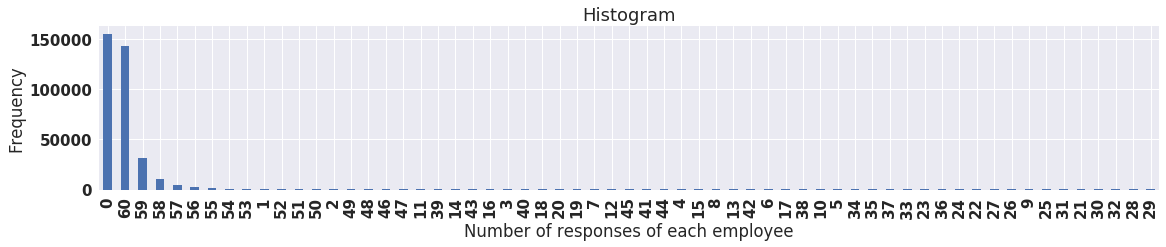

In [879]:
plt.figure(figsize=(19,3))
df['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

> This figure shows people usually left the last questions unanswered.

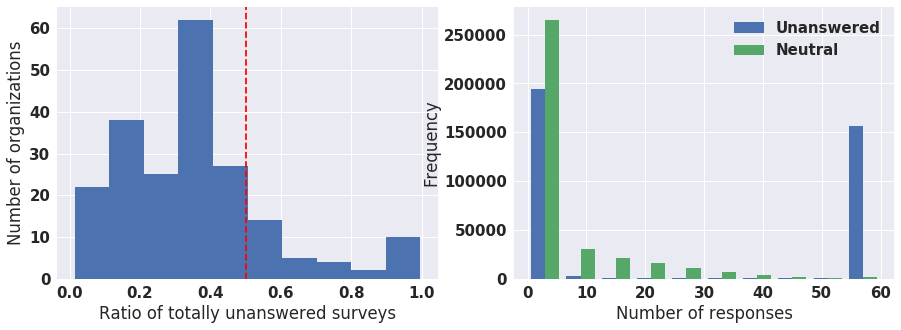

In [880]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
R = df[df['#Responses']!=0].groupby(['Survey' ])['#Responses'].count().copy()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of organizations')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-df['#Responses'])
s3 = df['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of different organizations, we can see the ratio of unanswered questions is mostly > 0.5.<br>
**Right figure**: The mejority of people either response to all or no questions(Blue bars). Usually people don't choose 3 as an answer(Green bars). I believe this shows that it is not a good way to consider the unanswered questions as neutral responses.

In [881]:
R.shape

(213,)

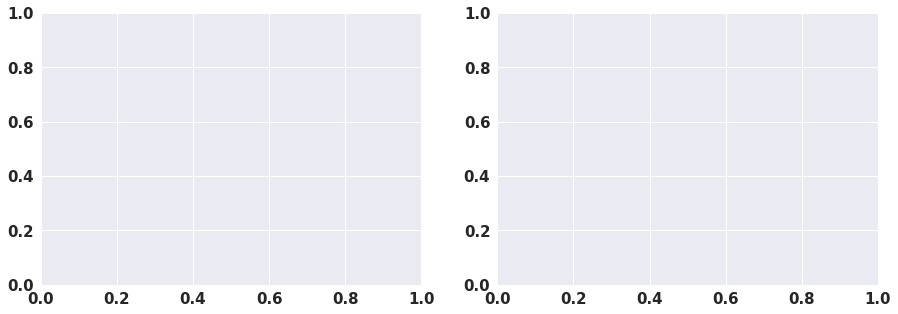

In [882]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
a = df[df['#Responses']==0]['Survey' ].unique()
# R = df.groupby(['Survey' ])['#Responses'].count().copy()
# plt.scatter(NR,R)

## Data imputation:
>  Unanswered questions:<br>
1- Can be removed<br>
2- Can be considred as neutral response 3<br>
3- Can fill in by the mod of responses<br>
4- Creating dummy features and include unanswered questions as a feature<br>

### List of manually categorized questions

In [891]:
bucket='insightdata-zahra'
data_key = 'Question List with Categories.xlsx'
data_location = 's3://{}/{}'.format(bucket, data_key)
sheet1 = 'Question List w Categories'
dfq = pd.read_excel(data_location)
sheet2 = 'Statements in each Category'
dfq2 = pd.read_excel(data_location,sheet2)
dfq.rename(columns={'Stmt_survey_num': 'Q_index','Question':'Questions'},inplace=True)

In [892]:
dfq

,Questions,Actionable,Q_index,Text,Categories
0,ti_1-resources,a,1,I am given the resources and equipment to do my job.,Supplies/Systems
1,ti_2,a,2,This is a physically safe place to work.,Supplies/Systems
2,ti_3,a,3,Everyone has an opportunity to get special recognition.,Appreciation/Recognition
3,ti_4-giving extra,a,4,People here are willing to give extra to get the job done.,Teamwork
4,ti_5-ppl cooperate,NaN,5,You can count on people to cooperate.,Teamwork
5,ti_6,a,6,Management makes its expectations clear.,Communication/Support
6,ti_7,a,7,I can ask management any reasonable question and get a straight answer.,Supplies/Systems
7,ti_8,a,8,I am offered training or development to further myself professionally.,Good incentives/growth
8,ti_9,a,9,Management shows appreciation for good work and extra effort.,Appreciation/Recognition
9,ti_10,a,10,People here are paid fairly for the work they do.,Good incentives/growth


In [893]:
# rename the qustion tags and remove the text part
dfq['Questions'] = dfq['Questions'].str.extract("(\S{2}_\d{1,})")
a = dfq[['Questions','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Questions')).copy()
Qs = a.iloc[:,0].tolist()
dfq = dfq.merge((df[df[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)


In [894]:
category = dfq[['Questions','Categories']].groupby('Categories').size()
category

Categories
Appreciation/Recognition            7
Balancing Personal/Productivity     5
Communication/Support               9
Good incentives/growth              6
Inspiring Work                     10
Management Integrity                9
Staffing and Scheduling             3
Supplies/Systems                    4
Teamwork                            7
dtype: int64

In [895]:
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values().copy()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

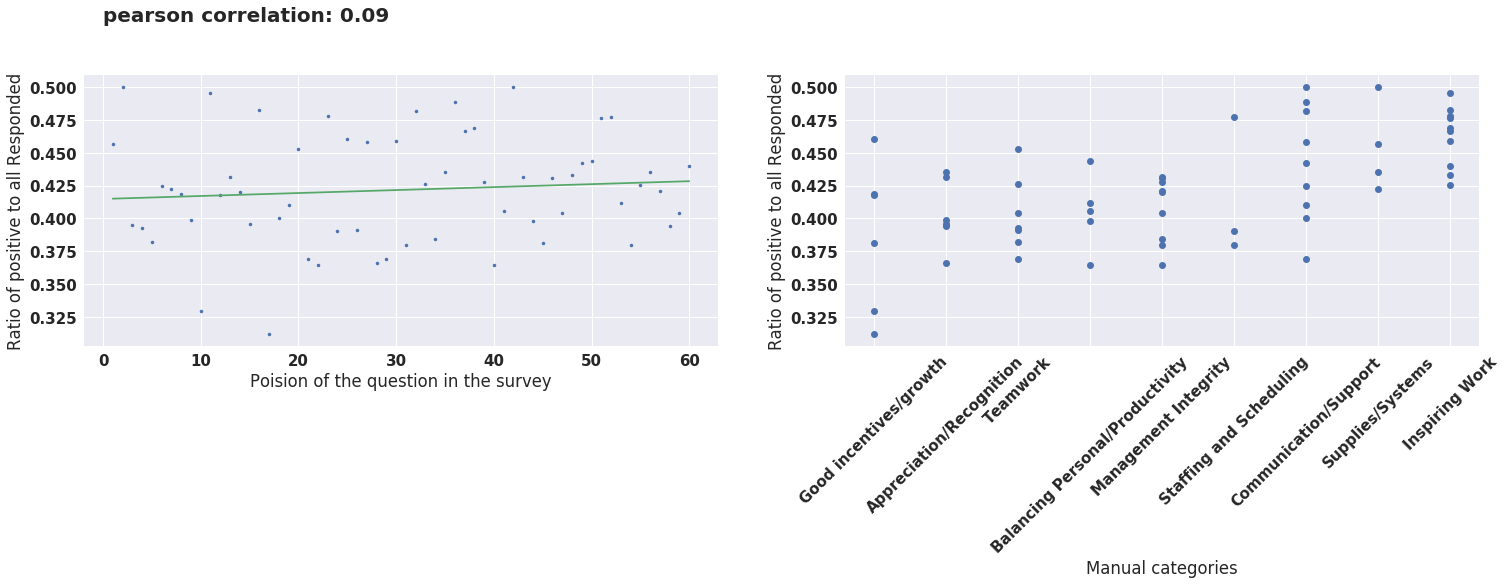

In [896]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].text(0,.55,"pearson correlation: "+str(round(np.corrcoef(dfq['Q_index'],dfq['Q-Score'])[0,1],2)),fontsize=20)
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

> **Left figure**: Score vs. Position of question in the survey. W can not see there is no correlation between the position of the question and the owerall score of the question.<br>
**Right figure**: This figure shows that in average, there is a correlation between the scores obtained by the questions in each category and the topic of categories.

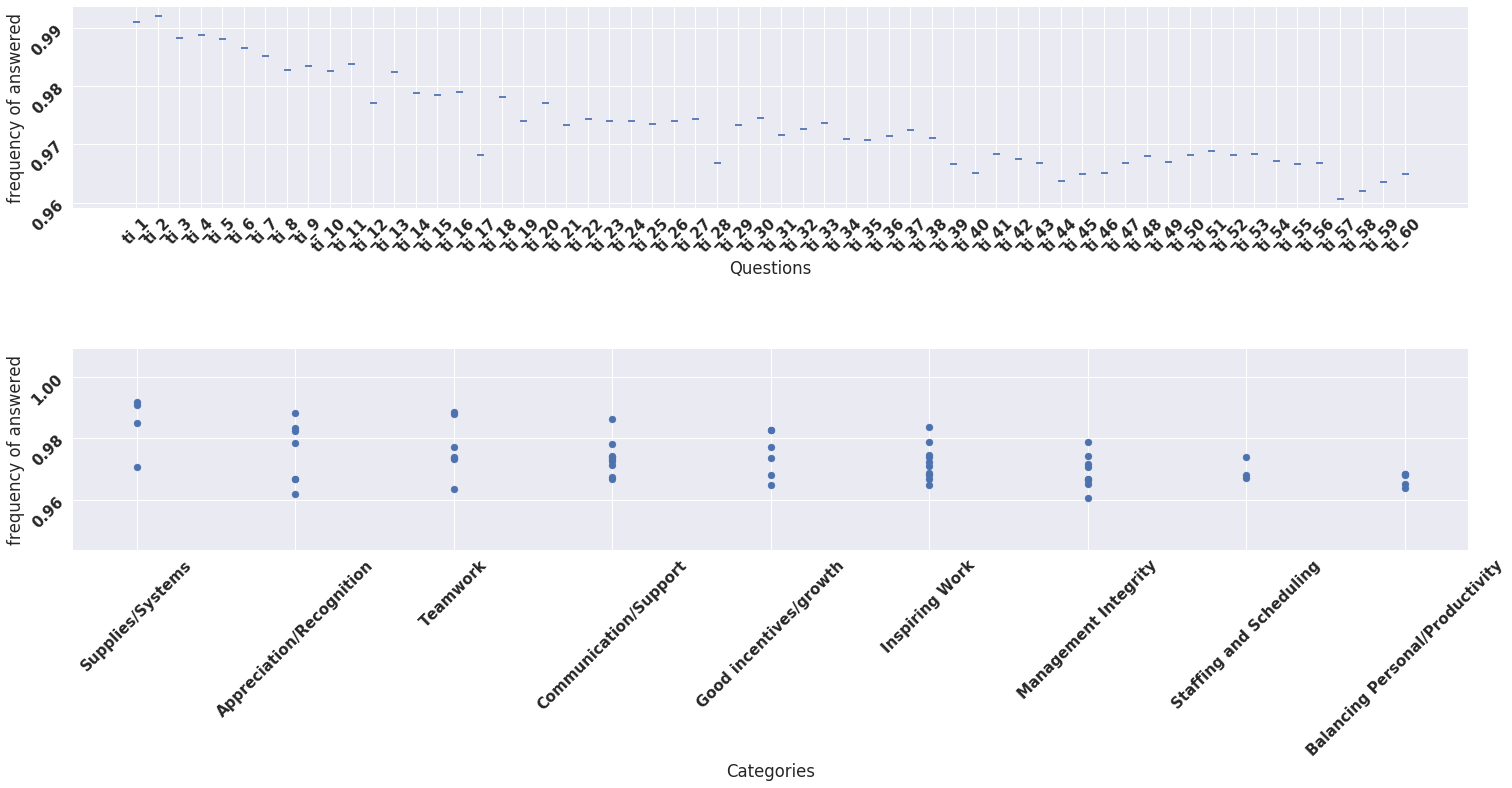

In [897]:
fig,ax = plt.subplots(2,1,figsize=(25,10))

dfc = df[df['#Responses']!=0].astype(bool).mean(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions').copy()

ax[0].scatter(x = dfc['Questions'] , y=dfc['Answered'],marker="_")
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answered')
ax[0].tick_params(labelrotation=45)

ax[1].scatter(x = dfc['Categories'] , y=dfc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

In [898]:
Inspiring_Work_Category =set(dfq[(dfq['Categories']=='Inspiring Work')]['Text'].index)-set([37])

In [899]:
aQs = dfq[dfq['Actionable']=='a']['Questions'].values.copy()
dfq = dfq.merge((df[df[aQs]!=0][aQs]>3).mean().to_frame('Q-Score_Actionables'),left_on='Questions',how='outer',right_index=True)

In [900]:
df['Actionable_Score']=(df[aQs]>3).sum(axis=1)/(df[aQs]!=0).sum(axis=1)

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [901]:
# It is poosible to use the 1-NMI as a measure of disctance between two sets of responses
# but mathematically it is proved that normalized metricated variant of mutual information is an entropic Jaccard distance.
# NMI = np.zeros([len(Qs),len(Qs)])
# for i in range(len(Qs)):
#     for j in range(len(Qs)):
#         NMI[i,j] = normalized_mutual_info_score(df[cl[i]],df[cl[j]])
# # indices_diagonal = np.diag_indices(len(NMI))
# # NMI[indices_diagonal] = .5
# Distance_Matrix=(1-NMI)/np.max(NMI)

In [902]:
df_non0 = df[df['#Responses']>0][Qs].T.copy()
d = distance.pdist(df_non0, metric='jaccard')
Distance_Matrix = distance.squareform(d)

In [903]:
# plt.figure(figsize=(10,7))

# sns.heatmap(Distance_Matrix)
# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')

> This figure shows the distance matrix of question, which shows how far questions from each other.

In [904]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

In [905]:
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# ZZ = dendrogram(
#     Z,
#     color_threshold=0.5,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=20.,  # font size for the x axis labels
# )
# plt.show()

> Dendogram illustrate the clusters of the questions. The dendogram colored when the tree is cut at .45.

In [906]:
max_d = .50
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T
clusters

array([3, 3, 3, 2, 4, 3, 2, 3, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 4, 3, 1,
       3, 1, 5, 4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 3, 2, 3, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

### Elbow Method

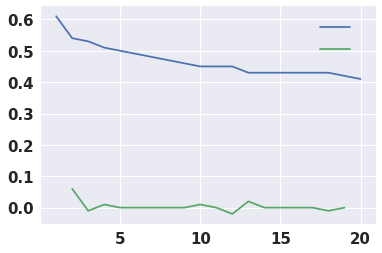

clusters: 2


In [907]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

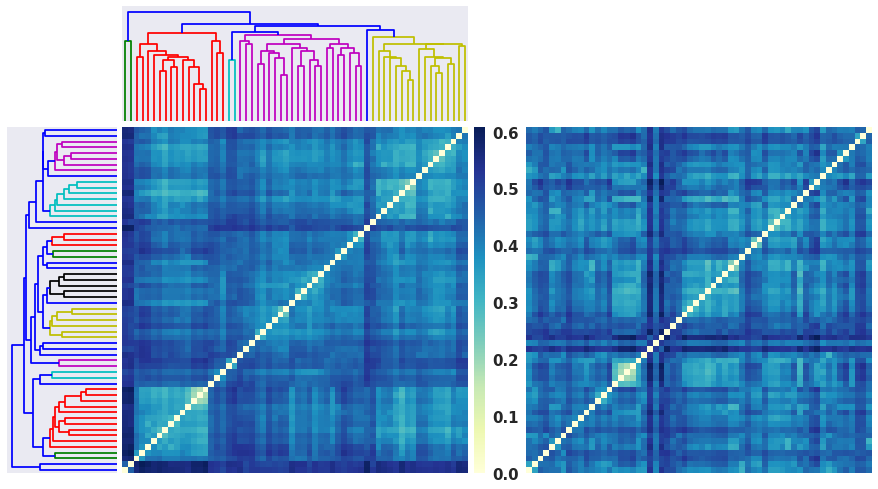

In [908]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.0,0.1,0.19,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.2,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.2,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.81,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)

# Plot distance matrix.
axmatrix = fig.add_axes([0.9,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(Distance_Matrix, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

fig.show()
fig.savefig('dendrogram.png')

> the clustered distance matrix and the mapping of the clusters are illustrated.

In [909]:

# Distance_Mat = Distance_Matrix.copy()
# Distance_Mat = Distance_Mat
# G = nx.from_numpy_matrix(Distance_Mat)
# test_values = clusters
# test_keys = range(60)
# mu = 0
# sigma = .1
# fixed_positions =  {test_keys[i]: (test_values[i]+random()/1,test_values[i]+random()/1) for i in range(len(test_keys))} 
# fixed_nodes = fixed_positions.keys()
# pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
# pos = nx.spring_layout(G)

# nx.draw(G, with_labels=True, node_size=500, node_color=clusters, pos=pos)


In [910]:
dfq.groupby('Clusters')['Q-Score'].mean()

Clusters
1    0.425338
2    0.408453
3    0.424864
4    0.425129
5    0.488881
Name: Q-Score, dtype: float64

> In the table below, you can see the questions which are categoried based on their cluster and their scare.

In [911]:
dfq[['Clusters','Categories','Actionable','Text','Q-Score']].sort_values(by='Q-Score').sort_values(by='Clusters').head(60)

,Clusters,Categories,Actionable,Text,Q-Score
21,1,Communication/Support,a,Management involves people in decisions that affect their jobs or work environment.,0.368876
23,1,Communication/Support,a,People here are treated fairly regardless of their race.,0.481800
30,2,Good incentives/growth,a,I feel I receive a fair share of the profits made by this organization.,0.311956
26,2,Communication/Support,a,I am treated as a full member here regardless of my position.,0.442031
3,2,Supplies/Systems,NaN,Our facilities contribute to a good working environment.,0.435201
6,2,Appreciation/Recognition,a,"Management is approachable, easy to talk with.",0.431757
49,2,Management Integrity,a,Management is honest and ethical in its business practices.,0.430915
47,2,Management Integrity,a,I believe management would lay people off only as a last resort.,0.427681
16,2,Teamwork,NaN,People care about each other here.,0.425852
18,2,Communication/Support,a,Management makes its expectations clear.,0.424569


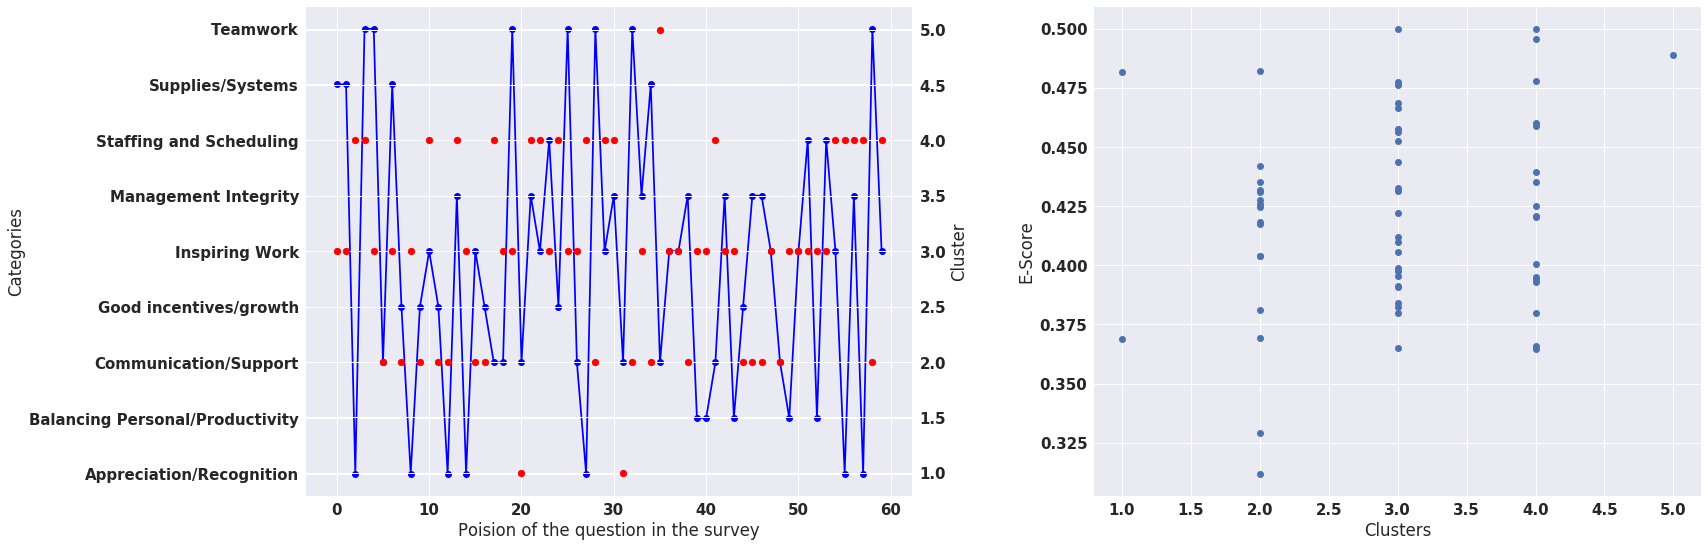

In [912]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Q_index')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Q-Score']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('E-Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

>**Right figure:** Shows the category and cluster of different questions vs their position in the survey. This figure shows that there is no correlation between the position of the question and the cluster/Category that each question related to.<br>
**Left figure:** This figure shows that on average there is a correlation between the score of the question and the cluster there are related to.

## Target variable
>In this section, we are looking for a measure to label the data, to develop a supervised ML model for that.<br>

>- On option is the score of each person, that is the ratio of positive responses to the number of responded questions. The problem with this score is that there are some non-actionable questions in the survey and using these questions in the scoring system would not help to improve the results we are going to interpret from the ML model.<br>
>- base on the description above, one scoring system is the ratio of positive actionable responses to all of the actionable responses.<br>
>- Last question of the survey asked employees "Taking everything into account, I would say this is a great place to work". This qistion is also a good feature to be used as a target variable.

In [913]:
# fig , ax = plt.subplots(2,6,figsize=(35,5),sharex=True,sharey=True)

# for i in range(6):
#     sns.barplot(x=Qs, y=df[df['ti_60']==i][Qs].mean(),ax=ax[0,i])
#     sns.barplot(x=Qs, y=df[(df['E-Score']<=(i)*.2) & (df['E-Score']>(i-1)*.2)][Qs].mean(),ax=ax[1,i])

In [914]:
perc = (df['#Responses'].value_counts()[0]/df['#Responses'].value_counts().sum()*100).copy()
print('{}% of employees have not left the entire survay blank.'.format(int(perc)))
perc = (df['#Responses'].value_counts()[2:].sum()/df['#Responses'].value_counts().sum()*100).copy()
print('{}% of employees have not compeleted the entire survay.'.format(int(perc)))

43% of employees have not left the entire survay blank.
16% of employees have not compeleted the entire survay.


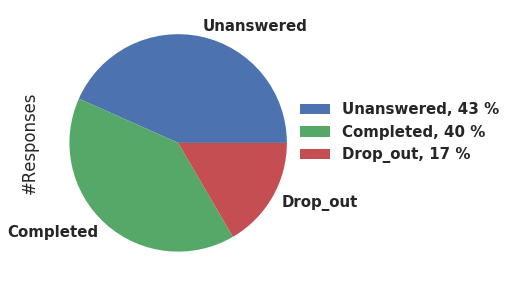

In [915]:
dfR = df['#Responses'].copy()
dfR[(dfR!=0)&(dfR!=60)]='Drop_out'
dfR[dfR==0]='Unanswered'
dfR[dfR==60]='Completed'
dfr = dfR.value_counts().to_frame()
piep = dfr.plot.pie( y = '#Responses' ,figsize=(5, 5))
plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])



Text(0, 0.5, 'E-Score')

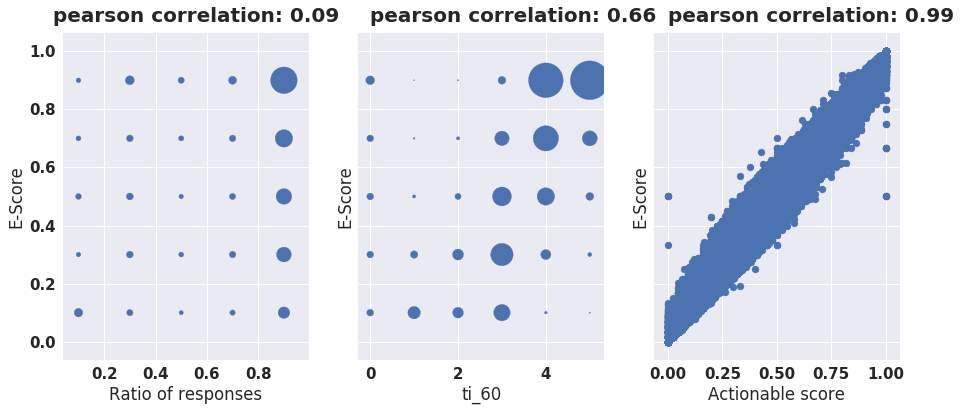

In [916]:
fig , ax = plt.subplots(1,3,figsize=(15,6),sharex=False,sharey=True)

X = (df['#Responses']/60).copy()
Y = (df['E-Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) -.05
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/5)
ax[0].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('E-Score')

X = df['ti_60'].copy()
Y = df['E-Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/20)
ax[1].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('E-Score')

X = df['Actionable_Score'].copy()
Y = df['E-Score'].copy()
X = X[~np.isnan(X) & ~np.isnan(Y)]
Y = Y[~np.isnan(X) & ~np.isnan(Y)]

ax[2].scatter(X,Y)
ax[2].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[2].set_xlabel('Actionable score')
ax[2].set_ylabel('E-Score')


> This figure shows:<br>
**Left figure:** There is no correlation between the number of responses and the finall score.<br>
**Middle figure:** There is a correlation between the finall score and employees response to the question they rank overally their workplace.<br>
**Right figure:** There is also a high correlation between the finall score and the actionable finall score.<br>

## Machine learning model development

> In this sesction I am going to apply the RandomForest Classifier, to find the most important questions that can predict the actionable score.

In [917]:
df.columns.values

array(['Survey', 'id', 'participant', 'Survey Code', 'started', 'ti_1',
       'ti_2', 'ti_3', 'ti_4', 'ti_5', 'ti_6', 'ti_7', 'ti_8', 'ti_9',
       'ti_10', 'ti_11', 'ti_12', 'ti_13', 'ti_14', 'ti_15', 'ti_16',
       'ti_17', 'ti_18', 'ti_19', 'ti_20', 'ti_21', 'ti_22', 'ti_23',
       'ti_24', 'ti_25', 'ti_26', 'ti_27', 'ti_28', 'ti_29', 'ti_30',
       'ti_31', 'ti_32', 'ti_33', 'ti_34', 'ti_35', 'ti_36', 'ti_37',
       'ti_38', 'ti_39', 'ti_40', 'ti_41', 'ti_42', 'ti_43', 'ti_44',
       'ti_45', 'ti_46', 'ti_47', 'ti_48', 'ti_49', 'ti_50', 'ti_51',
       'ti_52', 'ti_53', 'ti_54', 'ti_55', 'ti_56', 'ti_57', 'ti_58',
       'ti_59', 'ti_60', 'ti_positive', 'ti_inconsistent', 'ti_negative',
       'Tenure', 'Work Status', 'Pay Type', 'Birth Year (Range)',
       'Managerial Level', 'Confidence in Executive Team', 'Gender',
       'Race/Ethnicity', 'Meaningful Innovation Opportunities',
       'Disabilities', 'Responsibility', 'LGBT', 'Postal/Zip Code',
       'ti_unique', 'ti_ch

In [918]:
# Prepare the data
df_non0 = df[df['#Responses']>5].copy()
x = df_non0.loc[:,Qs+['#Responses','LeftAt']]
y = df_non0['Actionable_Score']
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [919]:
estimator = RandomForestRegressor(random_state=2)
param_grid = {
    'max_depth': [ 4, 5,7,10],
    'n_estimators': [10, 50,100,200],
    'min_samples_split':[5,8,10],
}
param_grid = {
    'max_depth': [ 5],
    'n_estimators': [100],
    'min_samples_split':[5],
}
RF = GridSearchCV(estimator, param_grid, cv=5,n_jobs=-1,verbose=10)
RF.fit(X_train, y_train)

print('Best parameters found by grid search are:', RF.best_params_)
y_predict = RF.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = RF.best_estimator_.score(X_train,y_predict)

y_predict = RF.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = RF.best_estimator_.score(X_test,y_predict)

print('The mean squared error on the train dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_train),y_train))
print('The pearson correlation coefficient between the predicted and real score on the train dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_train),y_train)[0,1])
print('The mean squared error on the test dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score on the test dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_test),y_test)[0,1])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.2s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
The mean squared error on the train dataset for the random forest model is:  0.007196402728101238
The pearson correlation coefficient between the predicted and real score on the train dataset is:  0.9586156121181463
The mean squared error on the test dataset for the random forest model is:  0.007348807053905666
The pearson correlation coefficient between the predicted and real score on the test dataset is:  0.9582780521719937


In [920]:
features=np.append(features,['#Responses','LeftAt'])
features

array(['ti_1', 'ti_2', 'ti_3', 'ti_4', 'ti_5', 'ti_6', 'ti_7', 'ti_8',
       'ti_9', 'ti_10', 'ti_11', 'ti_12', 'ti_13', 'ti_14', 'ti_15',
       'ti_16', 'ti_17', 'ti_18', 'ti_19', 'ti_20', 'ti_21', 'ti_22',
       'ti_23', 'ti_24', 'ti_25', 'ti_26', 'ti_27', 'ti_28', 'ti_29',
       'ti_30', 'ti_31', 'ti_32', 'ti_33', 'ti_34', 'ti_35', 'ti_36',
       'ti_37', 'ti_38', 'ti_39', 'ti_40', 'ti_41', 'ti_42', 'ti_43',
       'ti_44', 'ti_45', 'ti_46', 'ti_47', 'ti_48', 'ti_49', 'ti_50',
       'ti_51', 'ti_52', 'ti_53', 'ti_54', 'ti_55', 'ti_56', 'ti_57',
       'ti_58', 'ti_59', 'ti_60', '#Responses', 'LeftAt', '#Responses',
       'LeftAt'], dtype=object)

Feature ranking:


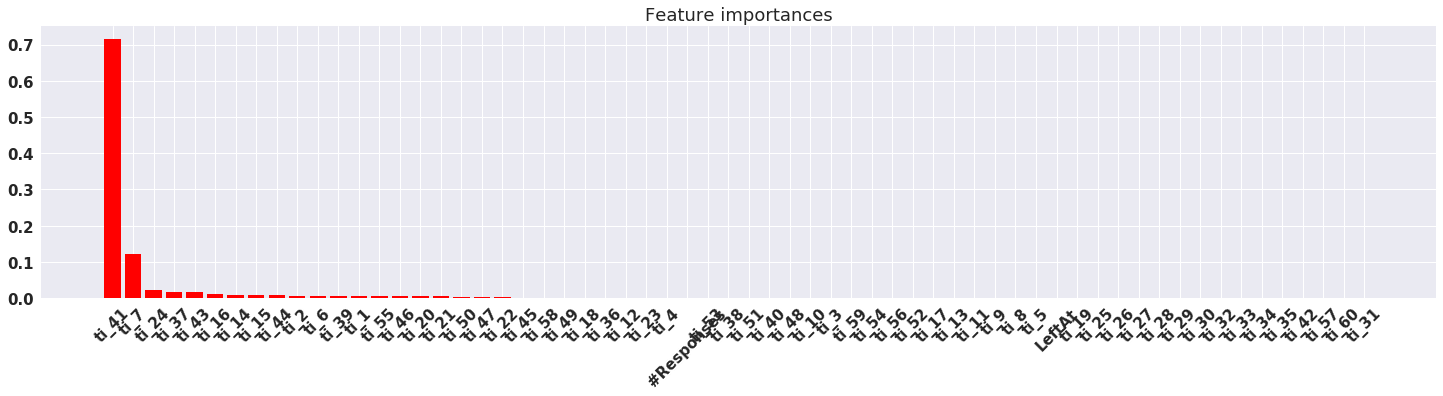

In [921]:
feature = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
features=np.append(feature,['#Responses','LeftAt'])
importances= RF.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices)), features[indices])
plt.xticks(rotation=45)
plt.show()

In [791]:
dfq[dfq['Questions'].isin(fx[idxf])]

,Question,Actionable,Stmt_survey_num,Text,Categories,Positive_to_Responded,mean_Positive_to_Responded,Positive_to_Responded_Actionables,Clusters
0,ti_1,a,1,I am given the resources and equipment to do my job.,Supplies/Systems,0.456217,0.453310,0.456217,3
1,ti_2,a,2,This is a physically safe place to work.,Supplies/Systems,0.499734,0.453310,0.499734,3
4,ti_3,a,3,Everyone has an opportunity to get special recognition.,Appreciation/Recognition,0.395010,0.402307,0.395010,4
11,ti_4,a,4,People here are willing to give extra to get the job done.,Teamwork,0.392953,0.402564,0.392953,4
12,ti_5,NaN,5,You can count on people to cooperate.,Teamwork,0.382385,0.402564,NaN,3
18,ti_6,a,6,Management makes its expectations clear.,Communication/Support,0.424569,0.441592,0.424569,2
2,ti_7,a,7,I can ask management any reasonable question and get a straight answer.,Supplies/Systems,0.422089,0.453310,0.422089,3
27,ti_8,a,8,I am offered training or development to further myself professionally.,Good incentives/growth,0.418419,0.386425,0.418419,2
5,ti_9,a,9,Management shows appreciation for good work and extra effort.,Appreciation/Recognition,0.398893,0.402307,0.398893,3
28,ti_10,a,10,People here are paid fairly for the work they do.,Good incentives/growth,0.329236,0.386425,0.329236,2


In [792]:
# idx = [int(i.split("_")[1])-1 for i in features[indices][:40]]
# dfq.reset_index(inplace=True)
fx = features[indices]
idxf = np.isin(fx,Qs)
idx = indices[idxf]
dfq.iloc[idx,:][['Questions','Actionable','Text']]#.to_frame()
# dfq[df['Questions'].isin(fx[idxf])][['Questions','Actionable','Text']]#.to_frame()

,Question,Actionable,Text
56,ti_41,a,People are encouraged to balance their work life and their personal life.
2,ti_7,a,I can ask management any reasonable question and get a straight answer.
52,ti_24,a,Management does a good job of assigning and coordinating people.
37,ti_37,NaN,I'm proud to tell others I work here.
48,ti_43,a,Management is competent at running the business.
34,ti_16,NaN,"When I look at what we accomplish, I feel a sense of pride."
43,ti_14,a,Management recognizes honest mistakes as part of doing business.
7,ti_15,a,Management genuinely seeks and responds to suggestions and ideas.
57,ti_44,a,"If I am unfairly treated, I believe I'll be given a fair shake if I appeal."
1,ti_2,a,This is a physically safe place to work.


In [822]:
dfc = df.copy()
1
dfc[dfc[Qs]==0]=np.nan
2
result0 = dfc.groupby(["Survey"])['id'].count().to_frame('tot').reset_index()
3
result = dfc[dfc['#Responses']!=0].groupby(["Survey"])['E-Score'].agg(['mean','count']).reset_index().sort_values('mean')
4
result = result.merge(result0,how='outer')

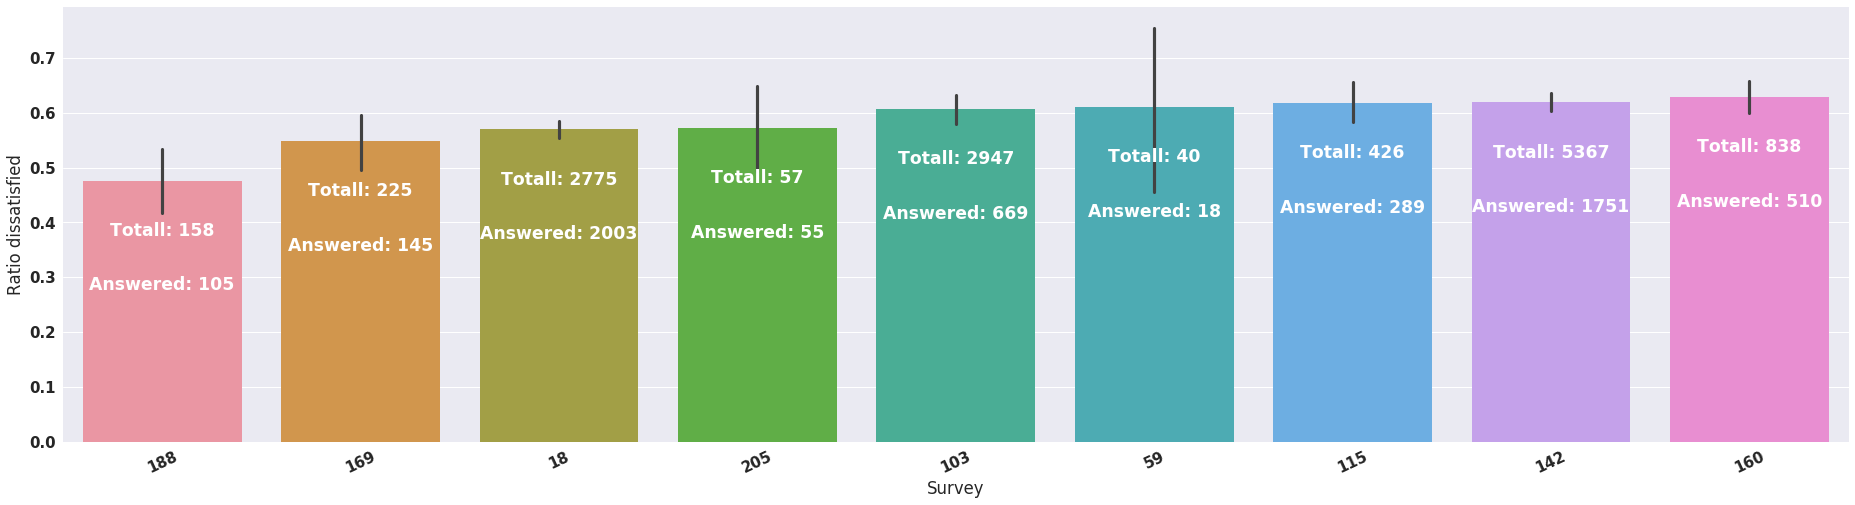

In [834]:
plt.figure(figsize=(32,8))
rez1 = result[result['mean']<.63]
dfcc = dfc[dfc['Survey'].isin(rez1['Survey'].values)]
ax = sns.barplot(x="Survey", y='E-Score', data=dfcc,order=rez1['Survey'])


medians = rez1.iloc[:,1]
nobs = rez1.iloc[:,2].astype(pd.Int32Dtype())
nobs0 = rez1.iloc[:,3].astype(pd.Int32Dtype())
nob0 = ["Totall: " + str(s) for s in list(nobs0)]
nob = ["Answered: " + str(s) for s in list(nobs)]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] - .1, nob0[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
    ax.text(pos[tick], medians[tick] - .2, nob[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
ax.set(ylabel='Ratio dissatisfied')
plt.xticks(rotation=25)
    
plt.show()

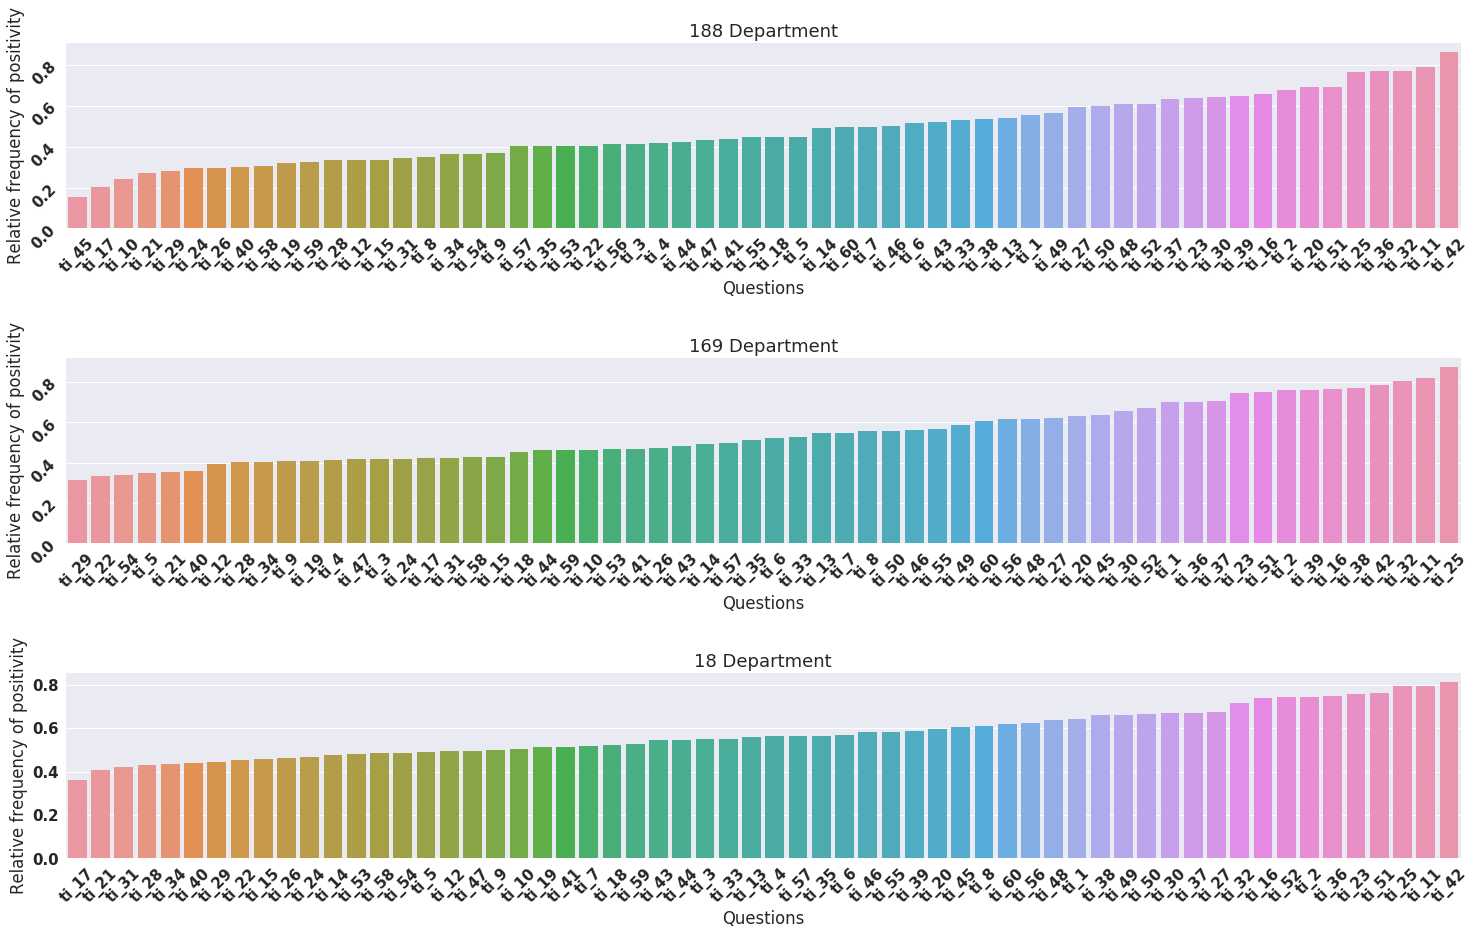

In [825]:
fig, ax = plt.subplots(3,1,figsize=(25,15))

resultdep = (dfc[dfc["Survey"]==result.iloc[0,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[0,0]][Qs]>0).sum(axis=0)).sort_values()

sns.barplot(x = resultdep.index,y=resultdep.values,ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title('{} Department'.format(result.iloc[0,0]))
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('Relative frequency of positivity')
idx0 = [int(i.split("_")[1])-1 for i in resultdep.index[:6]]


resultdep = (dfc[dfc["Survey"]==result.iloc[1,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[1,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[1])
ax[1].tick_params(labelrotation=45)
ax[1].set_title('{} Department'.format(result.iloc[1,0]))
ax[1].set_xlabel('Questions')
ax[1].set_ylabel('Relative frequency of positivity')
idx1 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]


resultdep = (dfc[dfc["Survey"]==result.iloc[2,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[2,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[2])
plt.xticks(rotation=45)
plt.title('{} Department'.format(result.iloc[2,0]))
ax[2].set_xlabel('Questions')
ax[2].set_ylabel('Relative frequency of positivity')
idx2 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]

plt.subplots_adjust(hspace=.7)
plt.show()

In [833]:
print('Organization {}'.format(result.iloc[1,0]))
dfq.iloc[idx1,:]['Text'].to_frame()

Organization 169


,Text
15,People look forward to coming to work here.
44,Managers avoid playing favorites.
54,Management hires people who fit in well here.
12,You can count on people to cooperate.
21,Management involves people in decisions that affect their jobs or work environment.
55,People avoid politicking and backstabbing as ways to get things done.
29,"When people change jobs or work units, they are made to feel right at home."


---
---



---
# Analyzing the data based on organization and location of care services

In [ ]:
print('Enter Id of the organization. A number from {} to {}:'.format(np.unique(df['Survey']).min(),np.unique(df['Survey']).max()))
Org = input()
print('From organization {} you can select one of the locations:'.format(Org))
loc = df[df['Survey']==int(Org)]['Location Name'].value_counts()
listt = list(zip(loc.index.values,loc.values))
dfc = pd.DataFrame(listt, columns = ['Location Name', '#Employees']) 
print(dfc)
print('Enter Id of the locatiom:')
loci = input()

print('You have chosen location {} from organization {}.'.format(dfc.iloc[int(loci),0],int(Org)))


In [ ]:
dforg = df[(df['Survey']==int(Org))]
dfloc = df[(df['Survey']==int(Org)) & (df['Location Name']== dfc.iloc[int(loci),0])]

In [ ]:
plt.figure(figsize=(19,5))
dforg['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(25,10))

dforgc = dforg.astype(bool).mean(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions')

ax[0].scatter(x = dforgc['Questions'] , y=dforgc['Answered'])
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answered')
ax[0].tick_params(labelrotation=45)

ax[1].scatter(x = dforgc['Categories'] , y=dforgc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

> In overall analysis we see that, people usually left the last questions unanswered.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = dforg[dforg['#Responses']==0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
R = dforg[dforg['#Responses']!=0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of locations')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-dforg['#Responses'])
s3 = dforg['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of This organizations, we can see the majority of the locations has a small (e.i. < 0.5) ratio of unanswered questions.<br>
**Right figure**: The mejority of people either response to all or no questions(Blue bars). Usually people don't choose 3 as an answer(Green bars). I believe this shows that it is not a good way to consider the unanswered questions as neutral responses.

In [ ]:
dfq.drop(columns=['mean_Q-Score','Q-Score'],inplace=True)
dfq = dfq.merge((dforg[dforg[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
# ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [ ]:
df_non0 = dforg[dforg['#Responses']!=0][Qs].T
d = distance.pdist(df_non0, metric='jaccard')
Distance_Matrix = distance.squareform(d)

In [ ]:
plt.figure(figsize=(10,7))

sns.heatmap(Distance_Matrix)
# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')

> This figure shows the distance matrix of question, which shows how far questions from each other.

In [ ]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ZZ = dendrogram(
    Z,
    color_threshold=0.45,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

> Dendogram illustrate the clusters of the questions. The dendogram colored when the tree is cut at .45.

In [ ]:
max_d = .50
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T
clusters

In [ ]:
### Elbow Method

In [ ]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [ ]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

> the clustered distance matrix and the mapping of the clusters are illustrated.

In [ ]:
dfq.groupby('Clusters')['Q-Score'].mean()

> In the table below, you can see the questions which are categoried based on their cluster and their scare.

In [ ]:
dfq[['Clusters','Actionable','Text','Q-Score']].sort_values(by='Q-Score').sort_values(by='Clusters').head(60)

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Q_index')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Q-Score']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('E-Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

## Machine learning model development

> In this sesction I am going to apply the RandomForest Classifier, to find the most important questions that can predict the actionable score.

In [ ]:
# Prepare the data
df_non0 = dforg[dforg['#Responses']>5]
x = df_non0.loc[:,Qs+['#Responses','LeftAt']]
y = df_non0['Actionable_Score']
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [ ]:
# lab_enc = preprocessing.LabelEncoder()
# y_train_encoded = lab_enc.fit_transform(y_train).astype('int')

In [ ]:
estimator = RandomForestRegressor(random_state=2)
param_grid = {
    'max_depth': [2,3, 4, 5],
    'n_estimators': [3, 5,10,50,100],
    'min_samples_split':[5,8,10],
}

RF = GridSearchCV(estimator, param_grid, cv=5,n_jobs=-1,verbose=10)
RF.fit(X_train, y_train)

print('Best parameters found by grid search are:', RF.best_params_)

In [ ]:

y_predict = RF.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = RF.best_estimator_.score(X_train,y_predict)

y_predict = RF.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = RF.best_estimator_.score(X_test,y_predict)

print('The mean squared error on the train dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_train),y_train))
print('The pearson correlation coefficient between the predicted and real score on the train dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_train),y_train)[0,1])
print('The mean squared error on the test dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score on the test dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_test),y_test)[0,1])

In [ ]:
features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values

features = np.append(features, ['#Responses','LeftAt'])

In [ ]:
features

In [ ]:


importances= RF.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices)), features[indices])
plt.xticks(rotation=45)
plt.show()

In [ ]:
features[indices][:40]

In [ ]:
# idx = [int(i.split("_")[1])-1 for i in features[indices][:40]]
# dfq.reset_index(inplace=True)
idxf = np.isin(features[indices],Qs)
# dfq.iloc[idx,:][['Questions','Actionable','Text']]#.to_frame()
dfq['Questions' == idxf][['Questions','Actionable','Text']]#.to_frame()

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,6),sharex=False,sharey=True)
for i in range(3):
    X = dforg.iloc[:,5+idx[i]].copy()
    Y = dforg['Actionable_Score'].copy()
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]

    xedges = np.arange(0, np.max(X) + 1,1)
    yedges = np.arange(0, np.max(Y) ,.2)+.1
    meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
    xedges = np.arange(0, np.max(X) + 1.5,1) -.5
    yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

    H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
    ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*2)
    ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
    ax[i].set_xlabel('ti_{}'.format(idx[i]))
    ax[i].set_ylabel('E-Score')
i = 3    
X = dforg.iloc[:,5+50].copy()
Y = dforg['Actionable_Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*2)
ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[i].set_xlabel('ti_{}'.format(60))
ax[i].set_ylabel('E-Score')
plt.show()

---
---
---
# Analyzing the data based on organization and location of care services

In [ ]:
print('Enter Id of the organization. A number from {} to {}:'.format(np.unique(df['Survey']).min(),np.unique(df['Survey']).max()))
Org = input()
print('From organization {} you can select one of the locations:'.format(Org))
loc = df[df['Survey']==int(Org)]['Location Name'].value_counts()
listt = list(zip(loc.index.values,loc.values))
dfc = pd.DataFrame(listt, columns = ['Location Name', '#Employees']) 
print(dfc)
print('Enter Id of the locatiom:')
loci = input()

print('You have chosen location {} from organization {}.'.format(dfc.iloc[int(loci),0],int(Org)))


In [ ]:
dfloc = df[(df['Survey']==int(Org)) & (df['Location Name']== dfc.iloc[int(loci),0])].copy()

In [ ]:
plt.figure(figsize=(19,5))
dfloc['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any. 

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(25,10))

dflocc = dfloc.astype(bool).mean(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions')

ax[0].scatter(x = dflocc['Questions'] , y=dflocc['Answered'])
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answered')
ax[0].tick_params(labelrotation=45)

ax[1].scatter(x = dflocc['Categories'] , y=dflocc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = dfloc[dfloc['#Responses']==0].groupby(['Survey' , 'Department Name'])['#Responses'].count()
R = dfloc[dfloc['#Responses']!=0].groupby(['Survey' , 'Department Name'])['#Responses'].count()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of Departments')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-dfloc['#Responses'])
s3 = dfloc['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [ ]:
dfq.drop(columns=['mean_Q-Score','Q-Score'],inplace=True)
dfq = dfq.merge((dfloc[dfloc[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
# ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [ ]:
# df_non0 = dfloc[dfloc[Qs]!=0][Qs].T
df_non0 = dfloc[dfloc['#Responses']!=0][Qs].T.copy()
d = distance.pdist(df_non0, metric='jaccard')
Distance_Matrix = distance.squareform(d)

In [ ]:
dfq

In [ ]:
# import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# fig,ax = plt.subplots(1,1,figsize=(10,7))

# sns.heatmap(Distance_Matrix)
# linkage = hc.linkage(Distance_Matrix, method='average')
# sns.clustermap(Distance_Matrix, row_linkage=linkage, col_linkage=linkage)
fig,ax = plt.subplots(1,1,figsize=(10,7))


linkage = hc.linkage(Distance_Matrix, method='average')
 g = sns.clustermap(Distance_Matrix, row_linkage=linkage, col_linkage=linkage)


# set the gridspec to only cover half of the figure
g.gs.update(left=0.05, right=0.45)

#create new gridspec for the right part
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
# create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])
# plot boxplot in the new axes
snssns.heatmap(Distance_Matrix, palette="Set2", ax = ax2)
plt.show()

# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')


In [ ]:
# import networkx as nx
# Distance_Mat = Distance_Matrix.copy()
# Distance_Mat = Distance_Mat>.5
# G = nx.from_numpy_matrix(1-Distance_Mat)
# G.name = 'Graph from pandas adjacency matrix'
# test_values = clusters
# test_keys = range(60)
# mu = 0
# sigma = .1
# fixed_positions =  {test_keys[i]: (test_values[i]+random.normal(mu, sigma, 1),test_values[i]+np.random.normal(mu, sigma, 1)) for i in range(len(test_keys))} 
# fixed_nodes = fixed_positions.keys()
# pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

# nx.draw(G, with_labels=True, node_size=500, node_color=clusters, pos=pos)

Distance_Mat = Distance_Matrix.copy()
Distance_Mat = Distance_Mat
G = nx.from_numpy_matrix(1-Distance_Mat)
G.name = 'Graph from pandas adjacency matrix'
test_values = clusters
test_keys = range(60)
mu = 0
sigma = .1
fixed_positions =  {test_keys[i]: (test_values[i]+random()/10,test_values[i]+random()/10) for i in range(len(test_keys))} 
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

nx.draw(G, with_labels=True, node_size=500, node_color=clusters, pos=pos)


In [ ]:
pos=nx.spring_layout(G)



In [ ]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ZZ = dendrogram(
    Z,
    color_threshold=0.65,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [ ]:
max_d = .6
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T

np.unique(clusters)

### Elbow Method

In [ ]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [ ]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.65,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

In [ ]:
dfq[['Clusters','Actionable','Text','Q-Score','Categories']].sort_values(by='Q-Score').sort_values(by='Clusters').head(60)

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Q_index')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Q-Score']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('E-Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

In [ ]:
perc = dfloc['#Responses'].value_counts()[0]/dfloc['#Responses'].value_counts().sum()*100
print('{}% of employees have left the entire survay blank.'.format(int(perc)))
perc = dfloc['#Responses'].value_counts()[2:].sum()/dfloc['#Responses'].value_counts().sum()*100
print('{}% of employees have not compeleted the entire survay.'.format(int(perc)))

In [ ]:
fig , ax = plt.subplots(1,3,figsize=(15,6),sharex=False,sharey=True)
X = (dfloc['#Responses']/60).copy()
Y = (dfloc['E-Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) 
yedges = np.arange(0, np.max(Y)+.2 ,.2) 

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*20)
ax[0].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('E-Score')

X = dfloc['ti_60'].copy()
Y = dfloc['E-Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) 

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*20)
ax[1].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('E-Score')

X = dfloc['Actionable_Score'].copy()
Y = dfloc['E-Score'].copy()
X = X[~np.isnan(X) & ~np.isnan(Y)]
Y = Y[~np.isnan(X) & ~np.isnan(Y)]

ax[2].scatter(X,Y)
ax[2].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[2].set_xlabel('Actionable score')
ax[2].set_ylabel('E-Score')



In [ ]:
# Prepare the data
df_non0 = dfloc[dfloc['#Responses']>5]
x = df_non0.loc[:,[[Qs,'#Responses',]]]
y = df_non0['Actionable_Score']
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [ ]:
estimator = RandomForestRegressor(random_state=2)
param_grid = {
    'max_depth': [2,3, 4, 5],
    'n_estimators': [3, 5,10,50,100],
    'min_samples_split':[5,8,10],
}

RF = GridSearchCV(estimator, param_grid, cv=5)
RF.fit(X_train, y_train)

print('Best parameters found by grid search are:', RF.best_params_)
y_predict = RF.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = RF.best_estimator_.score(X_train,y_predict)

y_predict = RF.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = RF.best_estimator_.score(X_test,y_predict)

print('The mean squared error on the train dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_train),y_train))
print('The pearson correlation coefficient between the predicted and real score on the train dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_train),y_train)[0,1])
print('The mean squared error on the test dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score on the test dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_test),y_test)[0,1])

In [ ]:

features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
importances= RF.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices)), features[indices])
plt.xticks(rotation=45)
plt.show()

In [ ]:
idx = [int(i.split("_")[1])-1 for i in features[indices][:10]]
# dfq.reset_index(inplace=True)
dfq.iloc[idx,:][['Questions','Actionable','Clusters','Categories','Text']]#.to_frame()

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,6),sharex=False,sharey=True)
for i in range(3):
    X = dfloc.iloc[:,5+idx[i]].copy()
    Y = dfloc['Actionable_Score'].copy()
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]

    xedges = np.arange(0, np.max(X) + 1,1)
    yedges = np.arange(0, np.max(Y) ,.2)+.1
    meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
    xedges = np.arange(0, np.max(X) + 1.5,1) -.5
    yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

    H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
    ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*10)
    ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
    ax[i].set_xlabel('ti_{}'.format(idx[i]))
    ax[i].set_ylabel('E-Score')
i = 3    
X = dfloc.iloc[:,5+50].copy()
Y = dfloc['Actionable_Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*10)
ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[i].set_xlabel('ti_{}'.format(60))
ax[i].set_ylabel('E-Score')
plt.show()

## Relative frequency of dissatisfaction

In [ ]:
dfloc[dfloc[Qs]!=0]

In [ ]:
dflocc.groupby(["Department Name"]).head()

In [ ]:
dflocc = dfloc.copy()
dflocc[dflocc[Qs]==0]=np.nan
result0 = dflocc.groupby(["Department Name"])['id'].count().to_frame('tot').reset_index()
result = dflocc[dflocc['#Responses']!=0].groupby(["Department Name"])['E-Score'].agg(['mean','count']).reset_index().sort_values('mean')
result = result.merge(result0,how='outer')
plt.figure(figsize=(32,8))
ax = sns.barplot(x="Department Name", y='E-Score', data=dflocc,order=result['Department Name'])


medians = result.iloc[:,1]
nobs = result.iloc[:,2].astype(pd.Int32Dtype())
nobs0 = result.iloc[:,3].astype(pd.Int32Dtype())
nob0 = ["Totall: " + str(s) for s in list(nobs0)]
nob = ["Answered: " + str(s) for s in list(nobs)]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] - .1, nob0[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
    ax.text(pos[tick], medians[tick] - .2, nob[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
ax.set(ylabel='%Dissatisfied(Q60)')
plt.xticks(rotation=25)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(25,15))

resultdep = (dflocc[dflocc["Department Name"]==result.iloc[0,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[0,0]][Qs]>0).sum(axis=0)).sort_values()

sns.barplot(x = resultdep.index,y=resultdep.values,ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title('{} Department'.format(result.iloc[0,0]))
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('Relative frequency of positivity')
idx0 = [int(i.split("_")[1])-1 for i in resultdep.index[:6]]


resultdep = (dflocc[dflocc["Department Name"]==result.iloc[1,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[1,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[1])
ax[1].tick_params(labelrotation=45)
ax[1].set_title('{} Department'.format(result.iloc[1,0]))
ax[1].set_xlabel('Questions')
ax[1].set_ylabel('Relative frequency of positivity')
idx1 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]


resultdep = (dflocc[dflocc["Department Name"]==result.iloc[2,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[2,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[2])
plt.xticks(rotation=45)
plt.title('{} Department'.format(result.iloc[2,0]))
ax[2].set_xlabel('Questions')
ax[2].set_ylabel('Relative frequency of positivity')
idx2 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]

plt.subplots_adjust(hspace=.7)
plt.show()

In [ ]:
print('{} Department'.format(result.iloc[0,0]))
dfq.iloc[idx0,:]['Text'].to_frame()

In [ ]:
print('{} Department'.format(result.iloc[1,0]))
dfq.iloc[idx1,:]['Text'].to_frame()

In [ ]:
print('{} Department'.format(result.iloc[2,0]))
dfq.iloc[idx2,:]['Text'].to_frame()

## Binnerize and generate dummy features

In [ ]:
df = pd.get_dummies(df, columns=["source",'country'])